# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from Resources.MCForecastTools import MCSimulation
from functions import get_json_request, get_crypto_price
import json
from datetime import date, timedelta

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_response = get_json_request(btc_url)
# print(json.dumps(btc_response, indent=4)) Preview response
btc_price = get_crypto_price(btc_response['data']['1'], 'CAD')
print(f'Current BTC price in CAD {btc_price}')

# Fetch current ETH price
eth_response = get_json_request(eth_url)
eth_price = get_crypto_price(eth_response['data']['1027'], 'CAD')
print(f'Current ETH price in CAD {eth_price}')

Current BTC price in CAD 23334.479025
Current ETH price in CAD 1731.38108


In [6]:
# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price
# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $28001.37
The current value of your 5.3 ETH is $9176.32


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca_api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [9]:
# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [10]:
# Format current date as ISO format
# Since I have a free subscription to Alpaca, using the current date returns an error:
# APIError: your subscription does not permit querying data from the past 15 minutes
# today = pd.Timestamp(date.today(), tz="America/New_York").isoformat()
# Thus for this case study we are using the date from 30 days ago instead.
a_month_ago = date.today() - timedelta(days=30)
today = pd.Timestamp(a_month_ago, tz="America/New_York").isoformat()

In [11]:
# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca_api.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df

df_portfolio

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2022-11-11 05:00:00+00:00,96.23,96.605,96.23,96.51,4945326,17243,96.478436,AGG
2022-11-11 05:00:00+00:00,395.59,399.350,393.61,398.51,93424999,650078,396.974145,SPY


In [12]:
# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG, SPY],axis=1, keys=tickers)

# Preview DataFrame
df_portfolio

AGG                                             \
                            open    high    low  close   volume trade_count   
timestamp                                                                     
2022-11-11 05:00:00+00:00  96.23  96.605  96.23  96.51  4945326       17243   

                                         SPY                          \
                                vwap    open    high     low   close   
timestamp                                                              
2022-11-11 05:00:00+00:00  96.478436  395.59  399.35  393.61  398.51   

                                                             
                             volume trade_count        vwap  
timestamp                                                    
2022-11-11 05:00:00+00:00  93424999      650078  396.974145

In [13]:
# Pick AGG and SPY close prices
agg_close_price = float(df_portfolio["AGG"]["close"])
spy_close_price = float(df_portfolio["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $96.51
Current SPY closing price: $398.51


In [14]:
# Compute the current value of shares
my_agg_value = agg_close_price * my_agg
my_spy_value = spy_close_price * my_spy


# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19925.50
The current value of your 200 AGG shares is $19302.00


### Savings Health Analysis

In [15]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
assets_data = {
    "amount": [my_btc_value + my_eth_value, my_agg_value + my_spy_value]
}

# Create savings DataFrame
df_savings = pd.DataFrame(assets_data, index=['crypto', 'shares'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,37177.694554
shares,39227.500000


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

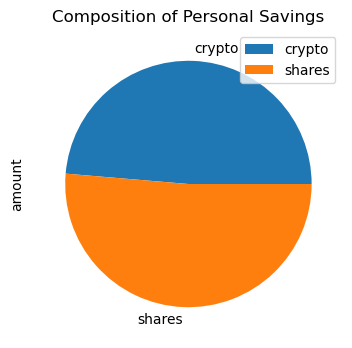

In [16]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title="Composition of Personal Savings", figsize=(4, 4))

In [17]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_amount_savings = df_savings.sum('rows')['amount']

# Validate saving health
if total_amount_savings > emergency_fund:
    emergency_fund_msg = 'Congratulations! You have enough money in your emergency fund.'
elif total_amount_savings == emergency_fund:
    emergency_fund_msg = 'Congratulations! You have reached the recommended amount for your emergency fund.'
else:
    emergency_amount_left = emergency_fund - total_amount_savings
    emergency_fund_msg = f'You have not reached the recommended amount for your emergency fund yet. You still need ${emergency_amount_left:0.2f}'
    
print(emergency_fund_msg)

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [18]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-05-10', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-05-10', tz='America/New_York').isoformat()

In [19]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca_api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol', axis=1)


# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG, SPY], axis=1, keys=tickers)

# Display sample data
df_stock_data.head()

AGG                                       \
                             open     high       low    close   volume   
timestamp                                                                
2017-05-10 04:00:00+00:00  108.60  108.660  108.4400  108.530  1653429   
2017-05-11 04:00:00+00:00  108.35  108.540  108.3435  108.520  2331142   
2017-05-12 04:00:00+00:00  108.81  108.940  108.7800  108.915  1329696   
2017-05-15 04:00:00+00:00  108.85  108.940  108.8200  108.880  1770999   
2017-05-16 04:00:00+00:00  108.88  109.101  108.8800  109.020  2051881   

                                                      SPY                    \
                          trade_count        vwap    open      high     low   
timestamp                                                                     
2017-05-10 04:00:00+00:00        8667  108.524494  239.39  239.8700  239.15   
2017-05-11 04:00:00+00:00        9679  108.486079  239.35  239.5700  238.13   
2017-05-12 04:00:00+00:00        7028  108.877713  239.08  239.4273  238.67   
2017-05-15 04:00:00+00:00       10064  108.894035  239.47  240.4400  239.45   
2017-05-16 04:00:00+00:00        9435  108.966110  240.64  240.6700  239.63   

                                                                       
                              close    volume trade_count        vwap  
timestamp                                                              
2017-05-10 04:00:00+00:00  239.8600  54293799      152415  239.618396  
2017-05-11 04:00:00+00:00  239.4592  62269354      211029  239.088106  
2017-05-12 04:00:00+00:00  239.0500  53912730      158255  239.000514  
2017-05-15 04:00:00+00:00  240.2297  61868937      193291  240.042085  
2017-05-16 04:00:00+00:00  240.0900  51241791      183988  240.104677

In [20]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
# Traditional 40/60 portfolio: 60% stocks (SPY) and 40% bonds (AGG). 
weights = [.40, .60]
MC_traditional_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = weights,
    num_simulation = 500,
    num_trading_days = 252*30 # 30 years
)

In [21]:
# Printing the simulation input data
MC_traditional_dist.portfolio_data.head()

AGG                                       \
                             open     high       low    close   volume   
timestamp                                                                
2017-05-10 04:00:00+00:00  108.60  108.660  108.4400  108.530  1653429   
2017-05-11 04:00:00+00:00  108.35  108.540  108.3435  108.520  2331142   
2017-05-12 04:00:00+00:00  108.81  108.940  108.7800  108.915  1329696   
2017-05-15 04:00:00+00:00  108.85  108.940  108.8200  108.880  1770999   
2017-05-16 04:00:00+00:00  108.88  109.101  108.8800  109.020  2051881   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-05-10 04:00:00+00:00        8667  108.524494          NaN  239.39   
2017-05-11 04:00:00+00:00        9679  108.486079    -0.000092  239.35   
2017-05-12 04:00:00+00:00        7028  108.877713     0.003640  239.08   
2017-05-15 04:00:00+00:00       10064  108.894035    -0.000321  239.47   
2017-05-16 04:00:00+00:00        9435  108.966110     0.001286  240.64   

                                                                             \
                               high     low     close    volume trade_count   
timestamp                                                                     
2017-05-10 04:00:00+00:00  239.8700  239.15  239.8600  54293799      152415   
2017-05-11 04:00:00+00:00  239.5700  238.13  239.4592  62269354      211029   
2017-05-12 04:00:00+00:00  239.4273  238.67  239.0500  53912730      158255   
2017-05-15 04:00:00+00:00  240.4400  239.45  240.2297  61868937      193291   
2017-05-16 04:00:00+00:00  240.6700  239.63  240.0900  51241791      183988   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-05-10 04:00:00+00:00  239.618396          NaN  
2017-05-11 04:00:00+00:00  239.088106    -0.001671  
2017-05-12 04:00:00+00:00  239.000514    -0.001709  
2017-05-15 04:00:00+00:00  240.042085     0.004935  
2017-05-16 04:00:00+00:00  240.104677    -0.000582

In [22]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_traditional_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/vhurtado/Sites/FinTech-Module5-Challenge/Resources/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999385,1.001639,0.996447,0.997674,1.004657,0.993207,0.993414,1.005292,0.984760,1.002598,...,0.989312,1.005681,0.992804,1.014150,1.000457,1.007121,0.992657,0.999874,1.004199,0.988512
2,1.004657,1.003757,1.003494,0.992781,1.010210,1.007435,0.989626,0.997942,0.978690,1.002653,...,0.998951,0.991170,0.988757,1.020085,1.001081,1.006610,0.994442,0.990650,0.995694,0.975072
3,1.005402,0.996429,1.010579,0.996414,1.010327,0.997466,1.002137,0.997667,0.991849,0.996470,...,0.989509,0.987256,1.000428,1.021846,1.013384,1.011378,0.998718,0.996240,0.993454,0.974187
4,1.008512,0.988379,1.018950,0.992240,1.012730,0.994334,1.003779,0.992067,0.997424,0.988697,...,0.989167,0.982312,0.994573,1.022093,1.019488,1.016896,1.008087,0.997938,0.985483,0.961641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,12.953290,11.806038,4.116457,4.756048,8.133716,10.081198,11.238501,5.611367,4.486645,2.680922,...,13.489744,3.115549,10.874768,11.854063,18.318048,5.319143,12.262553,6.881940,6.845144,2.496168
7557,13.071711,11.968455,4.158693,4.702158,8.237694,10.039030,11.200000,5.689360,4.561756,2.693989,...,13.339464,3.142433,10.881857,11.956156,18.205794,5.292411,12.284650,6.947342,6.871712,2.522434
7558,13.154365,11.894100,4.140507,4.667230,8.302149,10.063701,11.238665,5.745504,4.582324,2.686146,...,13.485664,3.066195,10.910020,11.811385,18.337865,5.299878,12.311052,6.977245,6.781655,2.538912
7559,13.090338,11.837600,4.161595,4.616249,8.351524,10.092485,11.301324,5.727535,4.592164,2.672181,...,13.480273,3.078584,10.874136,11.753455,18.361874,5.213741,12.356319,6.886090,6.802044,2.511785


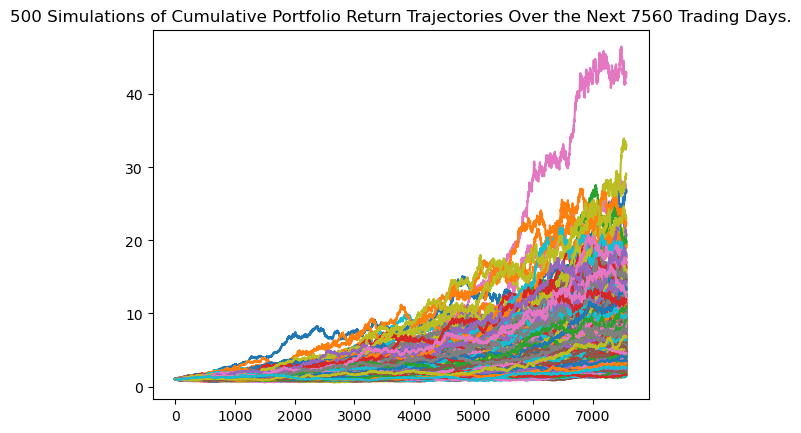

In [23]:
# Plot simulation outcomes
line_plot = MC_traditional_dist.plot_simulation()

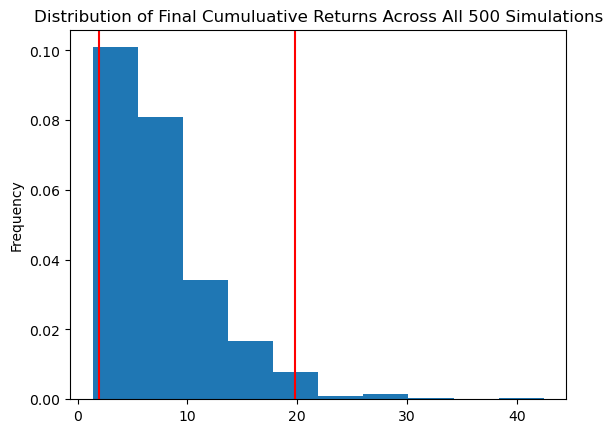

In [24]:
# Plot probability distribution and confidence intervals
dist_plot = MC_traditional_dist.plot_distribution()

### Retirement Analysis

In [25]:
# Fetch summary statistics from the Monte Carlo simulation results
traditional_tbl = MC_traditional_dist.summarize_cumulative_return()

# Print summary statistics
print(traditional_tbl)

count           500.000000
mean              7.617734
std               5.014842
min               1.391110
25%               4.217428
50%               6.230912
75%               9.618940
max              42.426885
95% CI Lower      1.919250
95% CI Upper     19.819253
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [26]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(traditional_tbl[8]*initial_investment,2)
ci_upper = round(traditional_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within the range of $38384.99 and $396385.06


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [27]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(traditional_tbl[8]*initial_investment,2)
ci_upper = round(traditional_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $57577.49 and $594577.59


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [28]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns

# Alternative 1: Keeping 60/40 strategy (60% stocks (SPY) and 40% bonds (AGG)) based on a 200% increase in the initial investment.
weights = [.40, .60]

MC_alt1_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = weights,
    num_simulation = 500,
    num_trading_days = 252*5 # 5 years
)

MC_alt1_dist.portfolio_data.head()

AGG                                       \
                             open     high       low    close   volume   
timestamp                                                                
2017-05-10 04:00:00+00:00  108.60  108.660  108.4400  108.530  1653429   
2017-05-11 04:00:00+00:00  108.35  108.540  108.3435  108.520  2331142   
2017-05-12 04:00:00+00:00  108.81  108.940  108.7800  108.915  1329696   
2017-05-15 04:00:00+00:00  108.85  108.940  108.8200  108.880  1770999   
2017-05-16 04:00:00+00:00  108.88  109.101  108.8800  109.020  2051881   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-05-10 04:00:00+00:00        8667  108.524494          NaN  239.39   
2017-05-11 04:00:00+00:00        9679  108.486079    -0.000092  239.35   
2017-05-12 04:00:00+00:00        7028  108.877713     0.003640  239.08   
2017-05-15 04:00:00+00:00       10064  108.894035    -0.000321  239.47   
2017-05-16 04:00:00+00:00        9435  108.966110     0.001286  240.64   

                                                                             \
                               high     low     close    volume trade_count   
timestamp                                                                     
2017-05-10 04:00:00+00:00  239.8700  239.15  239.8600  54293799      152415   
2017-05-11 04:00:00+00:00  239.5700  238.13  239.4592  62269354      211029   
2017-05-12 04:00:00+00:00  239.4273  238.67  239.0500  53912730      158255   
2017-05-15 04:00:00+00:00  240.4400  239.45  240.2297  61868937      193291   
2017-05-16 04:00:00+00:00  240.6700  239.63  240.0900  51241791      183988   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-05-10 04:00:00+00:00  239.618396          NaN  
2017-05-11 04:00:00+00:00  239.088106    -0.001671  
2017-05-12 04:00:00+00:00  239.000514    -0.001709  
2017-05-15 04:00:00+00:00  240.042085     0.004935  
2017-05-16 04:00:00+00:00  240.104677    -0.000582

In [29]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_alt1_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/vhurtado/Sites/FinTech-Module5-Challenge/Resources/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.010413,0.996423,0.999175,1.010200,1.008080,0.995573,1.000074,1.002900,1.002055,1.010705,...,1.014742,1.002278,1.000280,1.003696,0.983997,1.000687,1.000134,0.991196,1.001105,1.008671
2,1.000472,0.997039,0.997386,1.003671,1.006181,0.972130,1.005480,1.000938,1.005059,1.011410,...,1.016275,0.997932,0.988901,1.003386,0.988061,0.990773,0.995042,0.988847,1.006431,1.006317
3,1.004438,0.997255,0.989421,1.008177,1.000723,0.972048,0.993863,0.994771,1.002563,0.996990,...,1.004589,0.993608,1.004563,1.009332,1.003832,0.986144,0.994530,0.980258,1.003632,0.999460
4,0.988386,0.997863,0.997812,1.010861,0.990778,0.968242,0.997523,0.994189,1.006008,1.004544,...,1.005499,0.990413,1.004882,1.005081,0.999312,0.990600,0.994361,0.976684,0.998477,0.992327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.145394,0.949034,2.194595,1.875125,1.417454,0.957038,1.610967,1.243996,1.906704,1.650526,...,0.882024,1.209340,1.221841,1.650920,1.042663,1.538952,1.367575,1.402930,1.529677,0.856576
1257,1.141723,0.958974,2.198653,1.866548,1.402072,0.961574,1.624910,1.259250,1.953092,1.662542,...,0.881023,1.215648,1.223190,1.627366,1.055104,1.530312,1.377056,1.410356,1.529063,0.858086
1258,1.137055,0.950865,2.169148,1.852786,1.414274,0.960898,1.629070,1.280934,1.954587,1.662376,...,0.876196,1.209361,1.223683,1.632926,1.068422,1.539474,1.372130,1.413416,1.552718,0.865681
1259,1.161841,0.956264,2.182943,1.863534,1.434707,0.959759,1.610244,1.279990,1.936620,1.646607,...,0.874616,1.211807,1.231720,1.617383,1.063897,1.539563,1.388987,1.430358,1.554155,0.862297


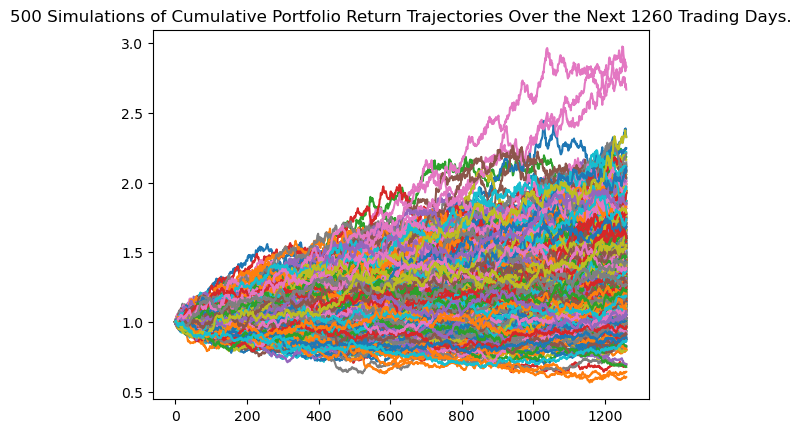

In [30]:
# Plot simulation outcomes
line_plot = MC_alt1_dist.plot_simulation()

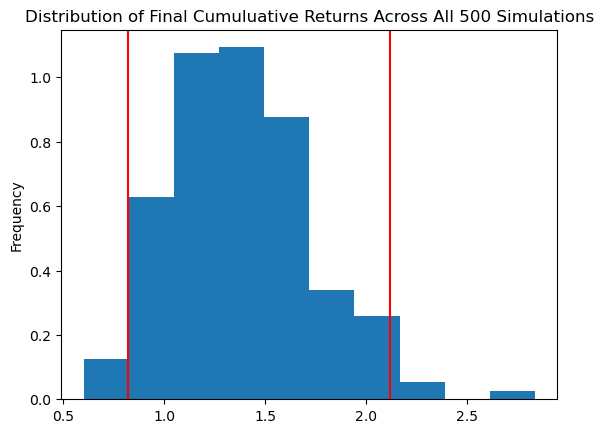

In [31]:
# Plot probability distribution and confidence intervals
dist_plot = MC_alt1_dist.plot_distribution()

In [32]:
# Fetch summary statistics from the Monte Carlo simulation results
alt1_tbl = MC_alt1_dist.summarize_cumulative_return()

# Print summary statistics
print(alt1_tbl)

count           500.000000
mean              1.383030
std               0.347109
min               0.603740
25%               1.127217
50%               1.347511
75%               1.581516
max               2.835342
95% CI Lower      0.823536
95% CI Upper      2.118795
Name: 1260, dtype: float64


In [33]:
# Set initial investment
initial_investment = 20000 * 3

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(alt1_tbl[8]*initial_investment,2)
ci_upper_five = round(alt1_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $49412.16 and $127127.69


### Ten Years Retirement Option

In [46]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns

# Alternative 2: Riskier portfolio: 80% stocks (SPY) and 20% bonds (AGG) based on a 200% increase in the initial investment.

weights = [.20, .80]

MC_alt2_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = weights,
    num_simulation = 500,
    num_trading_days = 252*10 # 10 years
)

MC_alt2_dist.portfolio_data.head()

AGG                                       \
                             open     high       low    close   volume   
timestamp                                                                
2017-05-10 04:00:00+00:00  108.60  108.660  108.4400  108.530  1653429   
2017-05-11 04:00:00+00:00  108.35  108.540  108.3435  108.520  2331142   
2017-05-12 04:00:00+00:00  108.81  108.940  108.7800  108.915  1329696   
2017-05-15 04:00:00+00:00  108.85  108.940  108.8200  108.880  1770999   
2017-05-16 04:00:00+00:00  108.88  109.101  108.8800  109.020  2051881   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-05-10 04:00:00+00:00        8667  108.524494          NaN  239.39   
2017-05-11 04:00:00+00:00        9679  108.486079    -0.000092  239.35   
2017-05-12 04:00:00+00:00        7028  108.877713     0.003640  239.08   
2017-05-15 04:00:00+00:00       10064  108.894035    -0.000321  239.47   
2017-05-16 04:00:00+00:00        9435  108.966110     0.001286  240.64   

                                                                             \
                               high     low     close    volume trade_count   
timestamp                                                                     
2017-05-10 04:00:00+00:00  239.8700  239.15  239.8600  54293799      152415   
2017-05-11 04:00:00+00:00  239.5700  238.13  239.4592  62269354      211029   
2017-05-12 04:00:00+00:00  239.4273  238.67  239.0500  53912730      158255   
2017-05-15 04:00:00+00:00  240.4400  239.45  240.2297  61868937      193291   
2017-05-16 04:00:00+00:00  240.6700  239.63  240.0900  51241791      183988   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-05-10 04:00:00+00:00  239.618396          NaN  
2017-05-11 04:00:00+00:00  239.088106    -0.001671  
2017-05-12 04:00:00+00:00  239.000514    -0.001709  
2017-05-15 04:00:00+00:00  240.042085     0.004935  
2017-05-16 04:00:00+00:00  240.104677    -0.000582

In [41]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_alt2_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/vhurtado/Sites/FinTech-Module5-Challenge/Resources/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991926,0.992447,1.000954,1.007452,1.012225,1.011433,1.001800,0.995528,0.998875,0.999693,...,1.000838,0.997473,0.985766,0.985318,0.996811,1.002994,1.014986,1.000677,0.993285,1.006124
2,0.995914,0.981193,0.990541,1.008952,1.014398,1.015034,1.005894,0.988082,1.006278,0.992999,...,1.001868,1.012562,0.997126,0.967145,0.998568,0.995220,1.026706,1.003371,0.985705,1.005530
3,0.996416,0.982124,0.998629,1.005838,1.012051,1.015296,1.002148,0.993807,1.014587,0.993460,...,1.012462,1.006084,1.001454,0.957731,0.993158,0.998347,1.017018,1.002217,0.980025,1.004389
4,0.984090,0.963269,0.991909,1.007489,1.018998,1.014723,0.999108,1.002384,1.020609,0.988799,...,1.011410,1.002156,1.014458,0.960697,0.983438,0.999298,1.011941,0.999836,0.973436,1.000918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.676900,2.250093,1.864883,0.829981,1.680669,2.659197,2.530335,1.565764,2.208834,2.120805,...,1.029499,1.781576,1.771877,1.738167,2.668131,1.229910,1.427904,1.546529,1.807127,1.480571
2517,1.665938,2.238706,1.851153,0.827882,1.677054,2.681277,2.538368,1.553551,2.213470,2.140814,...,1.027434,1.802355,1.795665,1.749419,2.666204,1.233163,1.413817,1.556099,1.800686,1.468530
2518,1.672843,2.265612,1.851789,0.829711,1.667062,2.685709,2.543862,1.570325,2.237118,2.099397,...,1.026931,1.805221,1.795754,1.760778,2.671771,1.223400,1.393113,1.551796,1.816768,1.461482
2519,1.697902,2.277157,1.867952,0.827046,1.660955,2.678708,2.562819,1.577244,2.236776,2.070642,...,1.030630,1.782181,1.787534,1.766608,2.681204,1.214896,1.393604,1.562848,1.811220,1.479968


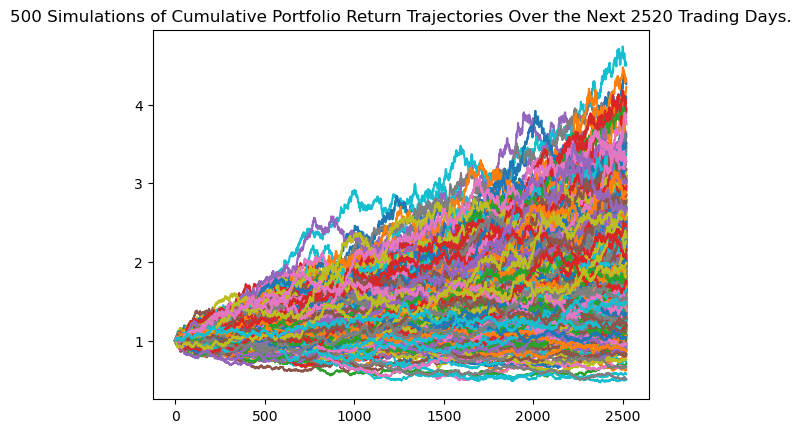

In [42]:
# Plot simulation outcomes
line_plot = MC_alt2_dist.plot_simulation()

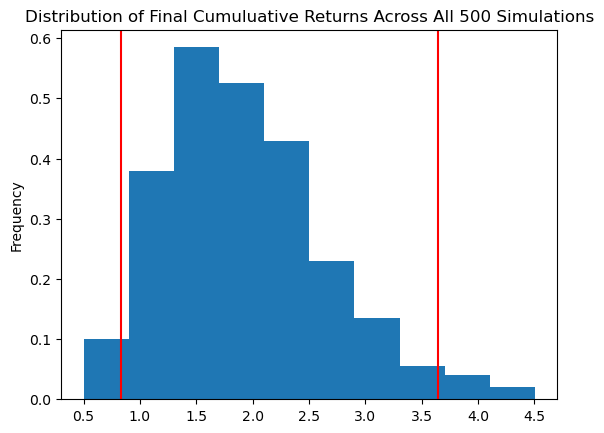

In [43]:
# Plot probability distribution and confidence intervals
dist_plot = MC_alt2_dist.plot_distribution()

In [44]:
# Fetch summary statistics from the Monte Carlo simulation results
alt2_tbl = MC_alt2_dist.summarize_cumulative_return()

# Print summary statistics
print(alt2_tbl)

count           500.000000
mean              1.934197
std               0.711963
min               0.503219
25%               1.438162
50%               1.813121
75%               2.332173
max               4.504359
95% CI Lower      0.827864
95% CI Upper      3.641167
Name: 2520, dtype: float64


In [45]:
# Set initial investment
initial_investment = 20000 * 3

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(alt2_tbl[8]*initial_investment,2)
ci_upper_ten = round(alt2_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $49671.85 and $218470.01


## Conclusion
When comparing the two Traditional portfolios over 30 years, increasing the initial investment by 50% results in an increase on both the lower and upper ends of the predicted value range by 50%, thus making an important difference at the end of the Time Horizon.

Exploring alternative portfolio strategies for an Early Retirement, it is evident that time has a significant impact when it comes to investment.

Although the initial investment is tripled to `$60,000.00` while maintaining a 60/40 strategy, the forecasted cumulative return over 5 years still indicates an almost **68% reduction** on the potential returns/savings. 

Forecasting the same `$60,000.00` with a more aggresive (and riskier) portfolio strategy (80% stocks and 20% bonds) over 10 years results in a more acceptable value range with roughly an **11% decrease** on the potential returns by the end of the Time Horizon, when compared to the *`$20,000.00` traditional portfolio over 30 years*.